In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets        import load_iris, load_breast_cancer
#데이터 분류 함수
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, make_scorer, precision_recall_curve
#분류 알고리즘
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression, LinearRegression
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing   import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

import seaborn as sns
from io import StringIO
import missingno as msno
import matplotlib.pyplot as plt

- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv('movies_test.csv')
submission = pd.read_csv('submission.csv')

display("<train>", train)
display("<test>", test)
submission

'<train>'

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387
...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,청소년 관람불가,심성보,3833.00,1,510,7,1475091
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,15세 관람가,윤종찬,496061.00,1,286,6,1716438
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,청소년 관람불가,김대현,NaN,0,123,4,2475
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,15세 관람가,백운학,NaN,0,431,4,2192525


'<test>'

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1
...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2.590000e+03,1,4,4
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,5.069900e+04,1,68,7


,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [ ]:
# 영화 장르에 따른 관객 수
group_genre = train.groupby('genre').sum()
# display(group_genre)
group_genre.rename(index={'공포':'Horror', '느와르':'Noir', '다큐멘터리':'Documentary', '드라마':'Drama', '멜로/로맨스':'Melodrama/Romance',
                          '뮤지컬':'Musical', '미스터리':'Mystery', '서스펜스': 'Suspense', '애니메이션':'Animation', '액션':'Action', '코미디':'Comedy'}, inplace=True)
group_genre.reset_index(level=0, inplace=True)
display(group_genre)

,genre,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,SF,1318,1.609684e+07,17,2565,48,23248494
1,Horror,4209,2.267451e+07,46,7408,163,24814966
2,Noir,3115,2.092276e+07,35,8399,97,61119768
3,Documentary,8189,4.299732e+06,37,1660,304,6247020
4,Drama,23128,8.118959e+07,180,36351,806,138277444
5,Melodrama/Romance,7538,4.803523e+07,77,10591,266,33225507
6,Musical,535,0.000000e+00,0,11,14,33135
7,Mystery,1744,9.927827e+06,21,1995,49,8968319
8,Suspense,224,5.342325e+05,2,222,6,165222
9,Animation,1734,5.323500e+04,1,937,119,3820460


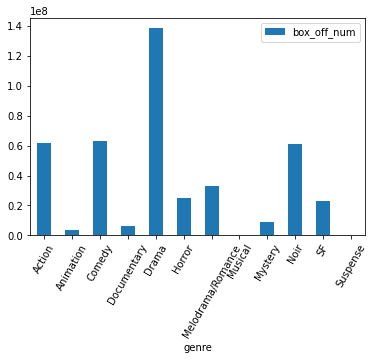

In [ ]:
group_genre[['genre', 'box_off_num']].groupby('genre').mean().plot(kind = "bar", rot = 60)

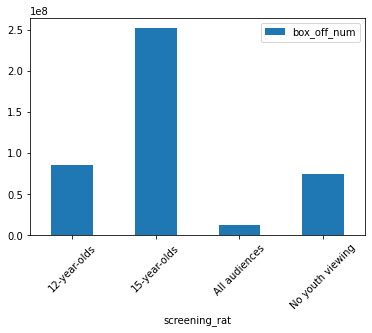

In [ ]:
# 연령 제한에 따른 영화 관객 수
group_agelimit = train.groupby('screening_rat').sum()
group_agelimit.rename(index={'12세 관람가':'12-year-olds', '15세 관람가':'15-year-olds', 
                                '전체 관람가':'All audiences', '청소년 관람불가':'No youth viewing'}, inplace=True)
group_agelimit.reset_index(level=0, inplace=True)
# display(group_agelimit)
group_agelimit[['screening_rat', 'box_off_num']].groupby('screening_rat').mean().plot(kind = "bar", rot = 45)

- LinearRegression를 이용한 그래프

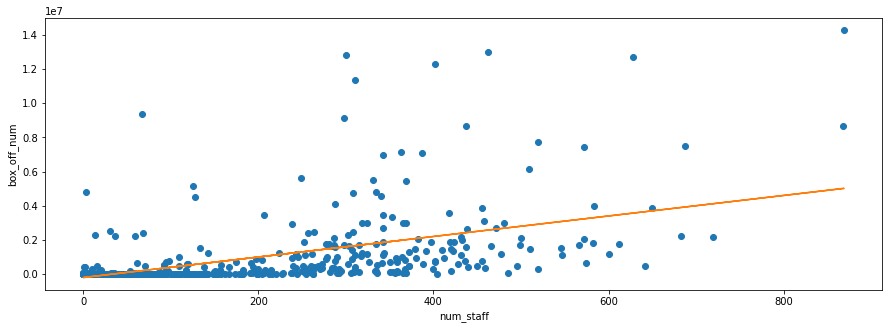

In [ ]:
X = train[['num_staff']]
Y = train[['box_off_num']]

linear_model = LinearRegression()
linear_model.fit(X, Y)
y_pred = linear_model.predict(X)
y_pred

plt.figure(figsize=(15,5))
plt.plot(X, Y, 'o')
plt.plot(X, y_pred)
plt.xlabel('num_staff')
plt.ylabel('box_off_num')
plt.show()
plt.close()

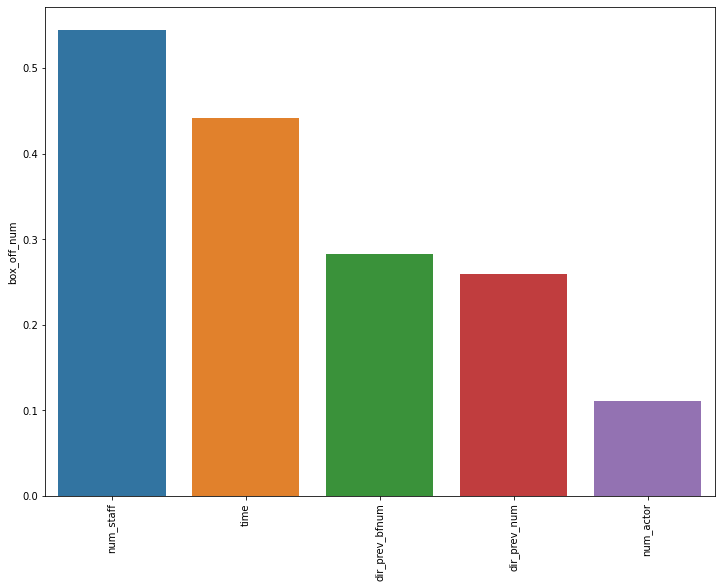

In [ ]:
plt.figure(figsize=(12,9)) # 사이즈 변경
plt.xticks(rotation = 90) # x축 text 회전
sns.barplot(x = abs(train.corr()["box_off_num"]).sort_values(ascending = False)[1:].index ,
            y = abs(train.corr()["box_off_num"]).sort_values(ascending = False)[1:]) # target을 제외하고 나머지와의 상관관계 시각화

- 결측치 처리

AxesSubplot(0.125,0.125;0.698618x0.755)
나이 데이터의 결측치 갯수


0

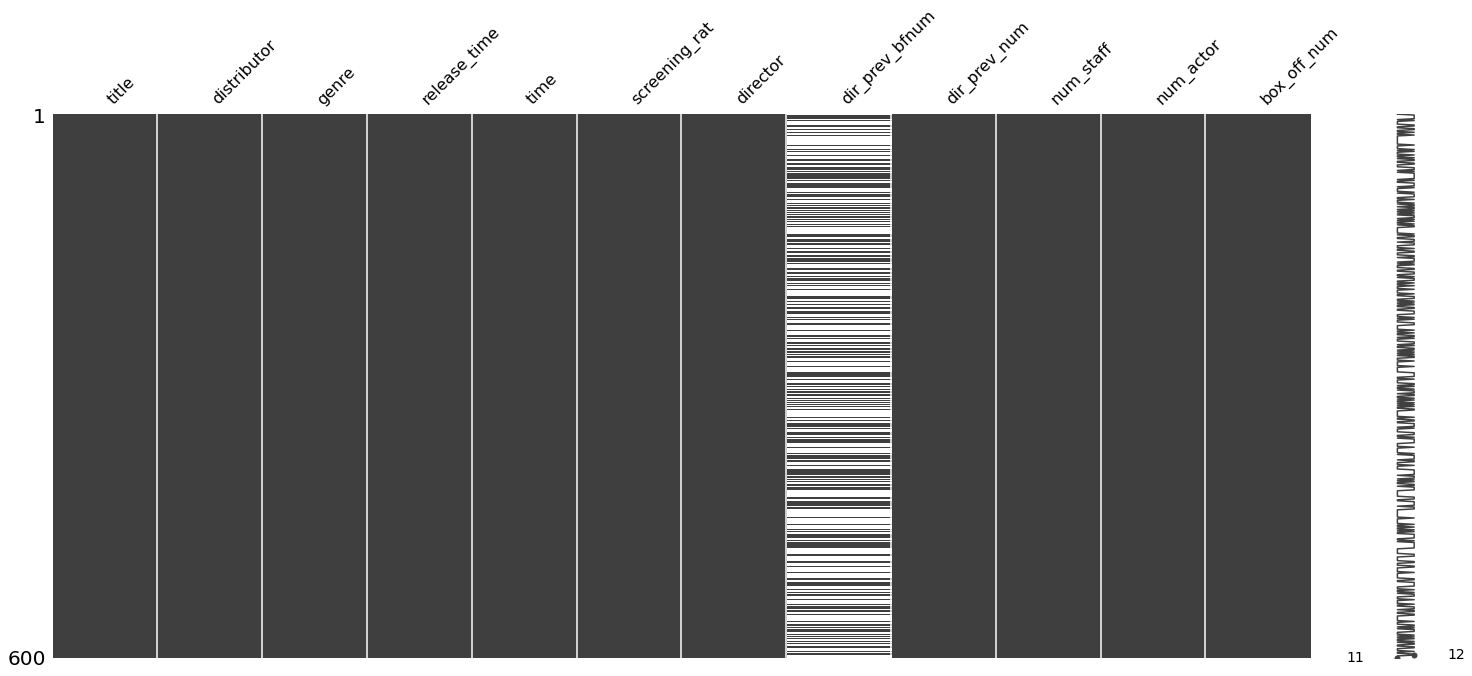

In [ ]:
print(msno.matrix(train))

print("나이 데이터의 결측치 갯수")
train['box_off_num'].isna().sum() #나이 데이터에 NaN 사라짐

In [ ]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


AxesSubplot(0.125,0.125;0.698618x0.755)


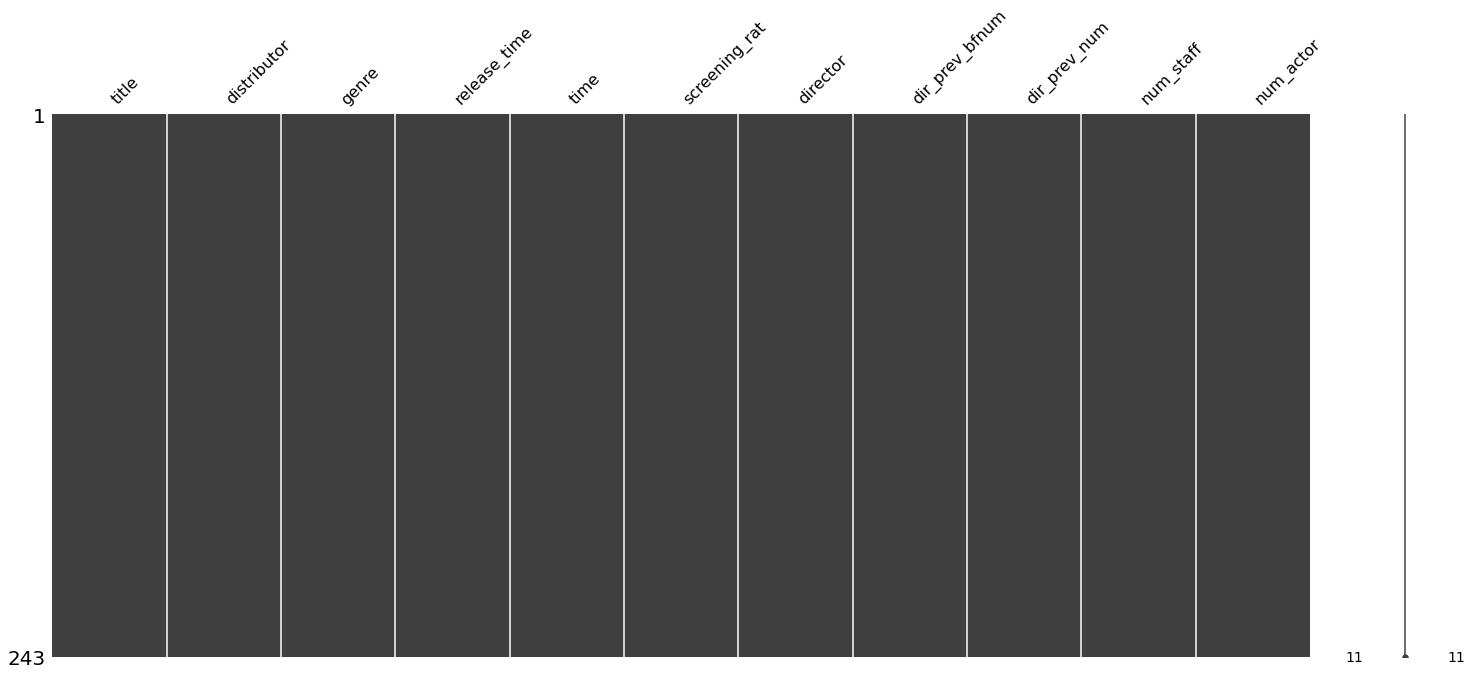

In [ ]:
train['dir_prev_bfnum'] = train['dir_prev_bfnum'].fillna(0)
test['dir_prev_bfnum'] = test['dir_prev_bfnum'].fillna(0)
print(msno.matrix(test))

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  243 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [ ]:
train_before = train.copy()#원본 데이터 보호
test_before = test.copy()

In [ ]:
train_before = pd.get_dummies(columns = ['screening_rat'], data = train_before)
test_before = pd.get_dummies(columns = ['screening_rat'], data = test_before)

display(train_before)
display(test_before)

,title,distributor,genre,release_time,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,조병옥,0.00,0,91,2,23398,0,0,0,1
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,우민호,1161602.50,2,387,3,7072501,0,0,0,1
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,장철수,220775.25,4,343,4,6959083,0,1,0,0
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,구자홍,23894.00,2,20,6,217866,0,0,1,0
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,신근호,1.00,1,251,2,483387,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,해무,(주)NEW,드라마,2014-08-13,111,심성보,3833.00,1,510,7,1475091,0,0,0,1
596,파파로티,(주)쇼박스,드라마,2013-03-14,127,윤종찬,496061.00,1,286,6,1716438,0,1,0,0
597,살인의 강,(주)마운틴픽쳐스,공포,2010-09-30,99,김대현,0.00,0,123,4,2475,0,0,0,1
598,악의 연대기,CJ 엔터테인먼트,느와르,2015-05-14,102,백운학,0.00,0,431,4,2192525,0,1,0,0


,title,distributor,genre,release_time,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,김형준,3.005290e+05,2,304,3,0,0,0,1
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,이광재,3.427002e+05,4,275,3,1,0,0,0
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,강대규,4.206611e+06,3,419,7,1,0,0,0
3,의형제,(주)쇼박스,액션,2010-02-04,116,장훈,6.913420e+05,2,408,2,0,1,0,0
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,권호영,3.173800e+04,1,380,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,안슬기,2.590000e+03,1,4,4,0,1,0,0
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,이일하,0.000000e+00,0,18,2,1,0,0,0
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,안용훈,0.000000e+00,0,224,4,0,0,0,1
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,송동윤,5.069900e+04,1,68,7,0,0,0,1


- 레이블 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

def label_encoder(dataframe_list, columns_list):
    for dataframe in dataframe_list:
        for columns in columns_list:
            encoder = LabelEncoder()
            dataframe[columns] = encoder.fit_transform(dataframe[columns])
    return dataframe

In [ ]:
#함수 실행
columns_list = ['title', 'distributor', 'genre', 'director']
dataframe_list = [train_before, test_before]
a = label_encoder(dataframe_list, columns_list)

#결과 확인
display(train_before)
display(test_before)

,title,distributor,genre,release_time,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,30,80,10,2012-11-22,96,393,0.00,0,91,2,23398,0,0,0,1
1,119,21,2,2015-11-19,130,252,1161602.50,2,387,3,7072501,0,0,0,1
2,425,21,10,2013-06-05,123,357,220775.25,4,343,4,6959083,0,1,0,0
3,96,6,11,2012-07-12,101,17,23894.00,2,20,6,217866,0,0,1,0
4,267,96,11,2010-11-04,108,218,1.00,1,251,2,483387,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,575,6,4,2014-08-13,111,231,3833.00,1,510,7,1475091,0,0,0,1
596,543,21,4,2013-03-14,127,266,496061.00,1,286,6,1716438,0,1,0,0
597,292,17,1,2010-09-30,99,44,0.00,0,123,4,2475,0,0,0,1
598,356,51,2,2015-05-14,102,195,0.00,0,431,4,2192525,0,1,0,0


,title,distributor,genre,release_time,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,153,64,2,2010-01-07,125,56,3.005290e+05,2,304,3,0,0,0,1
1,133,16,5,2010-01-14,113,126,3.427002e+05,4,275,3,1,0,0,0
2,219,29,4,2010-01-28,115,0,4.206611e+06,3,419,7,1,0,0,0
3,171,16,10,2010-02-04,116,175,6.913420e+05,2,408,2,0,1,0,0
4,213,29,1,2010-02-18,110,16,3.173800e+04,1,380,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,227,42,4,2015-11-19,78,107,2.590000e+03,1,4,4,0,1,0,0
239,161,80,3,2015-10-29,86,147,0.000000e+00,0,18,2,1,0,0,0
240,138,23,2,2015-10-28,107,108,0.000000e+00,0,224,4,0,0,0,1
241,77,18,4,2015-10-22,102,97,5.069900e+04,1,68,7,0,0,0,1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_

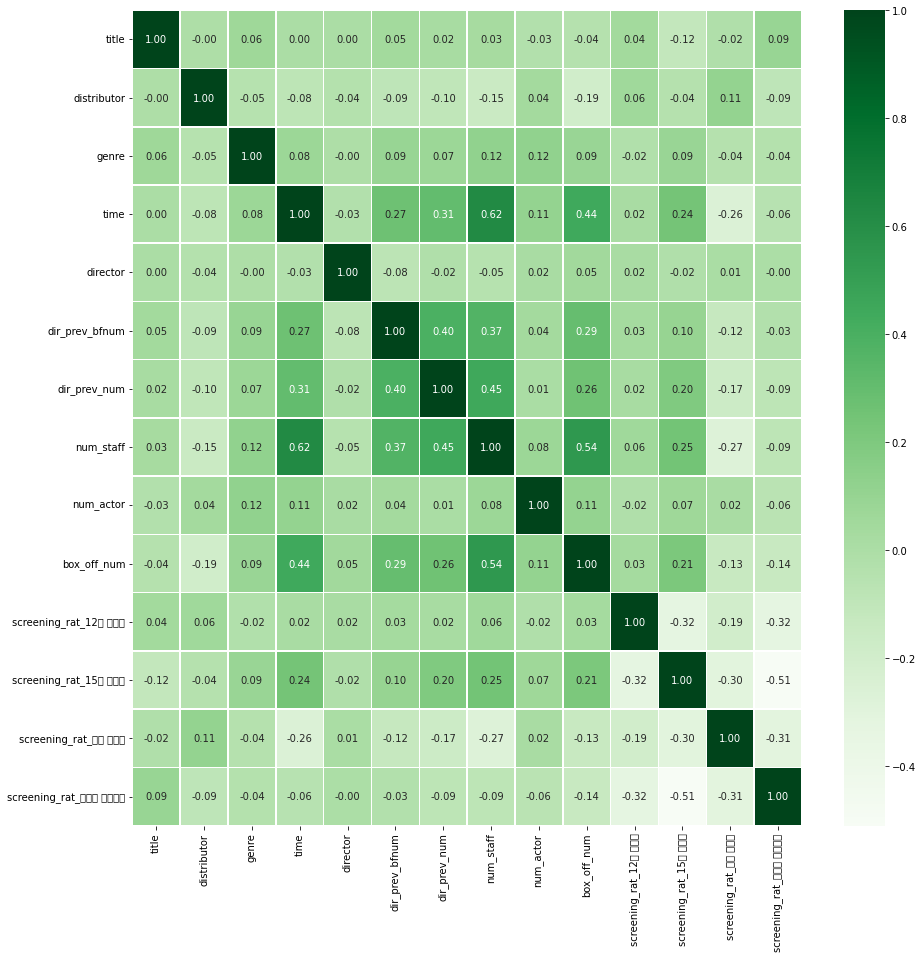

In [ ]:
#상관관계 표시
plt.figure(figsize=(15,15))
sns.heatmap(data = train_before.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Greens')
# 스태프 인원 수와 상영 시간이 여전히 크다

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_

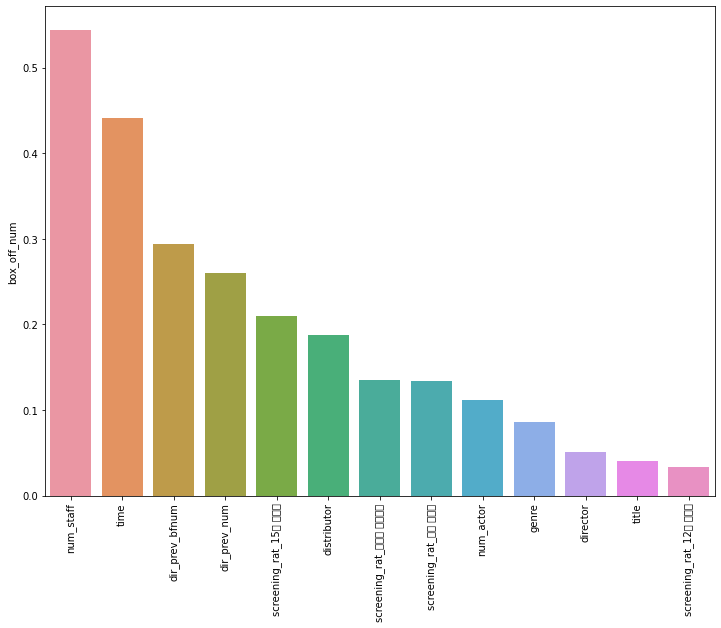

In [ ]:
plt.figure(figsize=(12,9)) # 사이즈 변경
plt.xticks(rotation = 90) # x축 text 회전
sns.barplot(x = abs(train_before.corr()["box_off_num"]).sort_values(ascending = False)[1:].index ,
            y = abs(train_before.corr()["box_off_num"]).sort_values(ascending = False)[1:]) # target을 제외하고 나머지와의 상관관계 시각화

- 이상치 처리

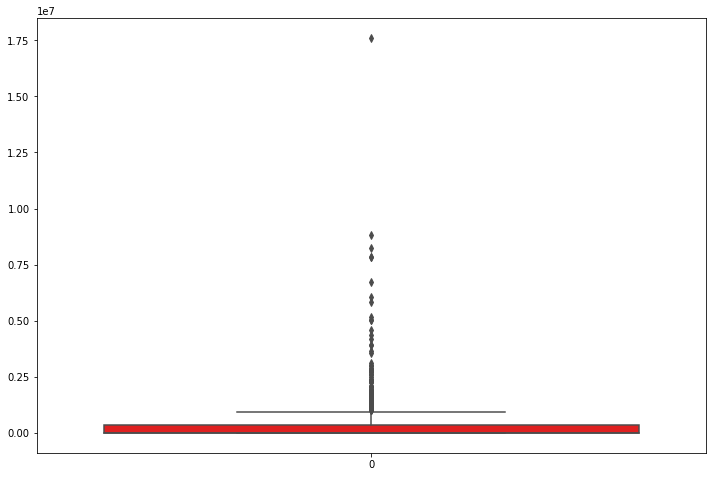

In [ ]:
import matplotlib.pyplot as plt
train_after = train_before.copy()
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_after['dir_prev_bfnum'], color='red')
plt.show()

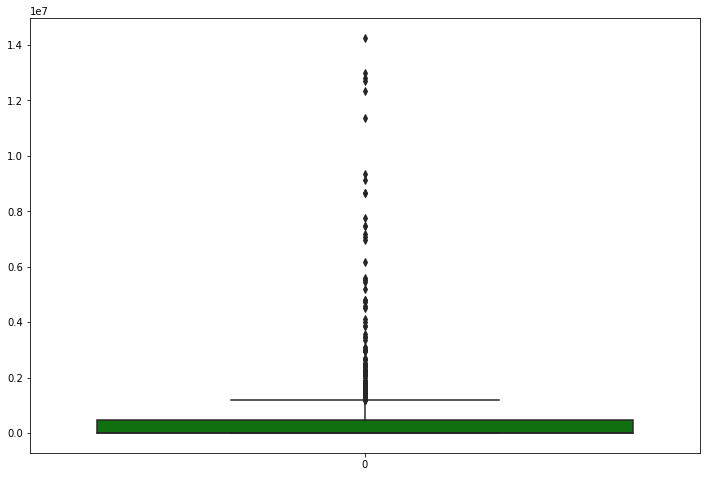

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_after['box_off_num'], color='green')
plt.show()

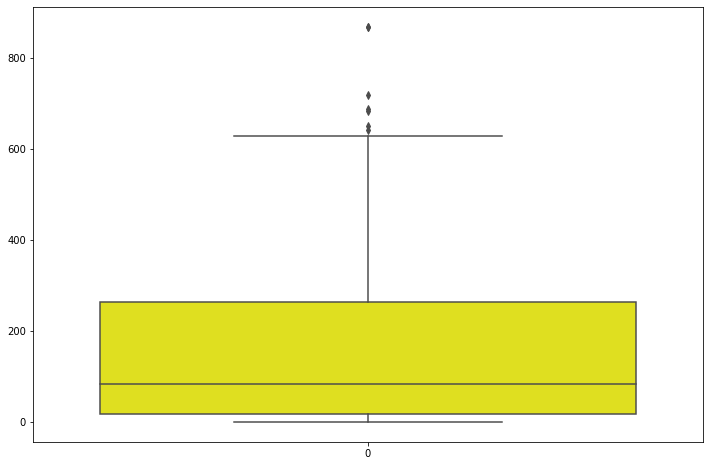

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_after['num_staff'], color='yellow')
plt.show()

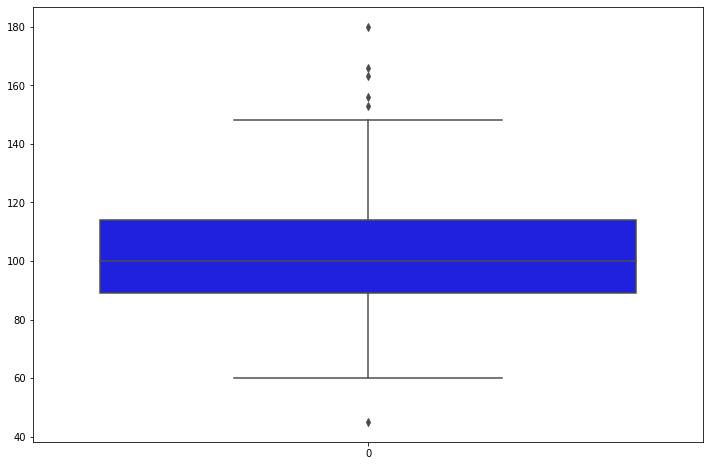

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_after['time'], color='blue')
plt.show()

In [ ]:
import numpy as np
#이상치 처리 함수 선언
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    return np.where((data > upper_bound) | (data < lower_bound))

In [ ]:
#이상치 처리 함수 적용
outlier_index_time = outliers_iqr(train_after['time'])[0]
outlier_index_staff = outliers_iqr(train_after['num_staff'])[0]
outlier_index_bfnum = outliers_iqr(train_after['dir_prev_bfnum'])[0]
outlier_index_boxoff = outliers_iqr(train_after['box_off_num'])[0]

#이상치 값 출력
print("time")
print(train_after.loc[outlier_index_time, 'time'])
print()
print('num_staff')
print(train_after.loc[outlier_index_staff, 'num_staff'])
print()
print('dir_prev_bfnum')
print(train_after.loc[outlier_index_bfnum, 'dir_prev_bfnum'])
print()
print('box_off_num')
print(train_after.loc[outlier_index_boxoff, 'box_off_num'])

time
209    163
377    180
422    153
438    166
477    156
545     45
Name: time, dtype: int64

num_staff
124    650
201    719
310    642
320    687
372    869
477    683
505    868
Name: num_staff, dtype: int64

dir_prev_bfnum
1      1.161602e+06
16     8.223342e+06
41     4.598985e+06
48     1.159954e+06
63     1.012310e+06
           ...     
551    2.723789e+06
564    1.887850e+06
568    1.389992e+06
576    1.030261e+06
588    2.061297e+06
Name: dir_prev_bfnum, Length: 90, dtype: float64

box_off_num
1      7072501
2      6959083
16     7453715
20     1624573
34     3009406
        ...   
592    1472147
595    1475091
596    1716438
598    2192525
599    7166532
Name: box_off_num, Length: 97, dtype: int64


In [ ]:
# 이상치 인덱스 모음집
outlier_index = np.concatenate((outlier_index_time,
                                outlier_index_staff,
                                outlier_index_bfnum,
                                outlier_index_boxoff), axis=None)
print(len(outlier_index))
outlier_index

200


array([209, 377, 422, 438, 477, 545, 124, 201, 310, 320, 372, 477, 505,
         1,  16,  41,  48,  63,  67,  76,  77,  81,  86,  90,  91, 100,
       101, 103, 106, 110, 116, 118, 123, 139, 142, 156, 161, 166, 175,
       182, 201, 206, 214, 218, 230, 244, 252, 259, 261, 287, 288, 292,
       297, 309, 310, 313, 320, 322, 326, 338, 352, 358, 360, 361, 362,
       377, 378, 382, 383, 395, 397, 399, 400, 408, 409, 412, 429, 431,
       433, 434, 455, 458, 460, 470, 476, 477, 486, 487, 498, 499, 505,
       516, 517, 518, 520, 527, 531, 535, 551, 564, 568, 576, 588,   1,
         2,  16,  20,  34,  39,  44,  59,  63,  66,  74,  81,  86,  90,
        91, 100, 101, 110, 112, 116, 118, 122, 124, 128, 139, 166, 169,
       178, 181, 190, 201, 208, 209, 214, 219, 220, 226, 244, 267, 278,
       287, 288, 297, 320, 322, 326, 360, 361, 362, 372, 377, 381, 382,
       388, 393, 397, 398, 399, 409, 412, 422, 429, 434, 442, 445, 455,
       458, 460, 466, 467, 472, 476, 477, 478, 485, 486, 487, 49

In [1]:
lead_not_outlier_index = []
for i in train_before.index:
    if i not in outlier_index:
        lead_not_outlier_index.append(i)
print(lead_not_outlier_index)

train_before_clean = train_before.loc[lead_not_outlier_index]
train_before_clean = train_before_clean.reset_index(drop=True)
#이상치 데이터가 전체 데이터의 22%인데, 과연 제거하는것이 좋은 방법일지??
train_before_clean

NameError: ignored

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52404 missing from current font.
  font.set_

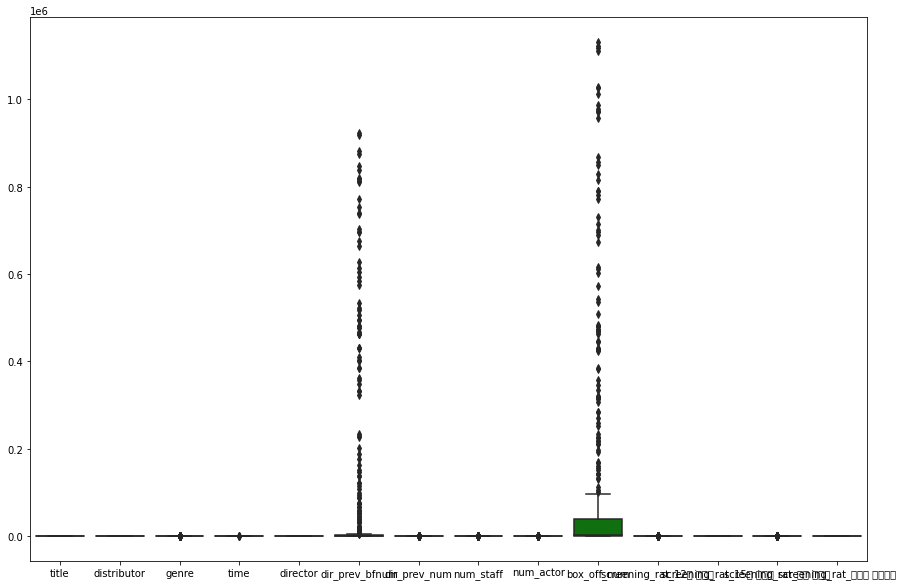

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_before_clean, color='green')
plt.show()

In [ ]:
#컬럼제거
train_before.drop(['release_time'], axis=1, inplace=True)
train_before_clean.drop(['release_time'], axis=1, inplace=True)
test_before.drop(['release_time'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_

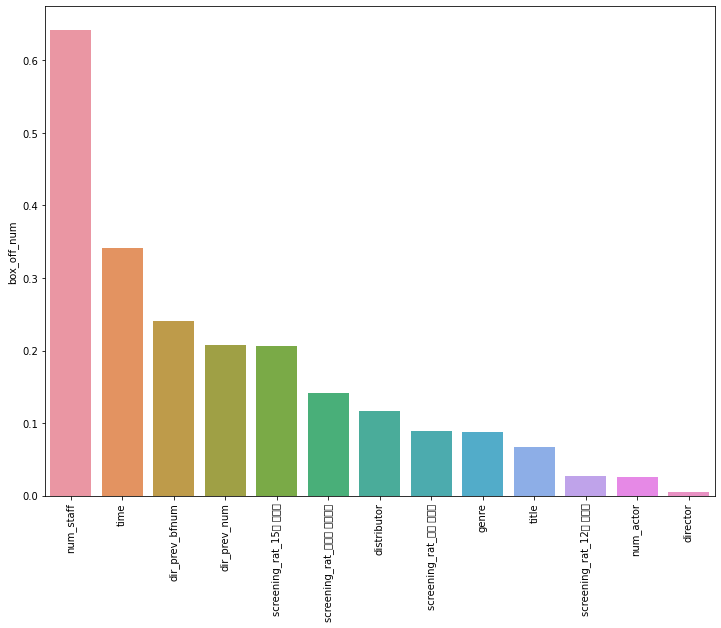

In [ ]:
plt.figure(figsize=(12,9)) # 사이즈 변경
plt.xticks(rotation = 90) # x축 text 회전
sns.barplot(x = abs(train_before_clean.corr()["box_off_num"]).sort_values(ascending = False)[1:].index ,
            y = abs(train_before_clean.corr()["box_off_num"]).sort_values(ascending = False)[1:]) # target을 제외하고 나머지와의 상관관계 시각화

In [ ]:
# test_after = train_before_clean.copy()

# train_before.drop(['director', 'num_actor', 'screening_rat_12세 관람가', 'title', 'genre','screening_rat_전체 관람가',
#                          'distributor', 'screening_rat_청소년 관람불가'], axis=1, inplace=True) #컬럼 제거
# test_before.drop(['director', 'num_actor', 'screening_rat_12세 관람가', 'title', 'genre','screening_rat_전체 관람가',
#                          'distributor', 'screening_rat_청소년 관람불가'], axis=1, inplace=True)

# display(train_before)
# display(test_before)

In [ ]:
# 데이터 나누기
X = train_before.drop(['box_off_num'], axis=1)
Y = train_before[['box_off_num']]
Z = test_before

display(X)
display(Y)
display(Z)


X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y,
                                                   test_size=0.2,
                                                   random_state=111)
X_train1.shape, X_test1.shape, Y_train1.shape, Y_test1.shape
print(Y_test1)

,title,distributor,genre,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,30,80,10,96,393,0.00,0,91,2,0,0,0,1
1,119,21,2,130,252,1161602.50,2,387,3,0,0,0,1
2,425,21,10,123,357,220775.25,4,343,4,0,1,0,0
3,96,6,11,101,17,23894.00,2,20,6,0,0,1,0
4,267,96,11,108,218,1.00,1,251,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,575,6,4,111,231,3833.00,1,510,7,0,0,0,1
596,543,21,4,127,266,496061.00,1,286,6,0,1,0,0
597,292,17,1,99,44,0.00,0,123,4,0,0,0,1
598,356,51,2,102,195,0.00,0,431,4,0,1,0,0


,box_off_num
0,23398
1,7072501
2,6959083
3,217866
4,483387
...,...
595,1475091
596,1716438
597,2475
598,2192525


,title,distributor,genre,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,153,64,2,125,56,3.005290e+05,2,304,3,0,0,0,1
1,133,16,5,113,126,3.427002e+05,4,275,3,1,0,0,0
2,219,29,4,115,0,4.206611e+06,3,419,7,1,0,0,0
3,171,16,10,116,175,6.913420e+05,2,408,2,0,1,0,0
4,213,29,1,110,16,3.173800e+04,1,380,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,227,42,4,78,107,2.590000e+03,1,4,4,0,1,0,0
239,161,80,3,86,147,0.000000e+00,0,18,2,1,0,0,0
240,138,23,2,107,108,0.000000e+00,0,224,4,0,0,0,1
241,77,18,4,102,97,5.069900e+04,1,68,7,0,0,0,1


     box_off_num
305         1351
294          162
373         3177
282         3333
24          1176
..           ...
280         5648
576       953682
368          166
97         22525
318      1025243

[120 rows x 1 columns]


실험 1

In [ ]:
# 데이터 나누기
X = train_before.drop(['box_off_num'], axis=1)
Y = train_before[['box_off_num']]
Z = test_before

# 로그 변환
X['num_staff'] = np.log1p(X['num_staff'])
X['time'] = np.log1p(X['time'])
X['dir_prev_bfnum'] = np.log1p(X['dir_prev_bfnum'])

Y['box_off_num'] = np.log1p(Y['box_off_num'])

Z['num_staff'] = np.log1p(Z['num_staff'])
Z['time'] = np.log1p(Z['time'])
Z['dir_prev_bfnum'] = np.log1p(Z['dir_prev_bfnum'])

display(X)
display(Y)
display(Z)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                   test_size=0.2,
                                                   random_state=32)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,title,distributor,genre,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,30,80,10,4.574711,393,0.000000,0,4.521789,2,0,0,0,1
1,96,6,11,4.624973,17,10.081425,2,3.044522,6,0,0,1,0
2,267,96,11,4.691348,218,0.693147,1,5.529429,2,0,1,0,0
3,28,80,11,4.736198,259,13.638738,2,5.572154,4,0,1,0,0
4,83,90,3,4.653960,320,0.000000,0,3.496508,5,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,476,51,7,4.744932,396,0.000000,0,4.532599,2,0,0,0,1
454,354,111,11,4.624973,200,0.000000,0,4.094345,4,0,0,0,1
455,113,160,7,4.584967,422,0.000000,0,1.791759,3,0,0,0,1
456,396,17,11,4.553877,127,0.000000,0,3.637586,5,0,0,0,1


,box_off_num
0,10.060449
1,12.291640
2,13.088575
3,12.359703
4,10.887941
...,...
453,7.131699
454,9.560222
455,7.032624
456,7.580189


,title,distributor,genre,time,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,153,64,2,4.836282,56,12.613303,2,5.720312,3,0,0,0,1
1,133,16,5,4.736198,126,12.744614,4,5.620401,3,1,0,0,0
2,219,29,4,4.753590,0,15.252168,3,6.040255,7,1,0,0,0
3,171,16,10,4.762174,175,13.446391,2,6.013715,2,0,1,0,0
4,213,29,1,4.709530,16,10.365301,1,5.942799,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,227,42,4,4.369448,107,7.859799,1,1.609438,4,0,1,0,0
239,161,80,3,4.465908,147,0.000000,0,2.944439,2,1,0,0,0
240,138,23,2,4.682131,108,0.000000,0,5.416100,4,0,0,0,1
241,77,18,4,4.634729,97,10.833681,1,4.234107,7,0,0,0,1


((366, 13), (92, 13), (366, 1), (92, 1))

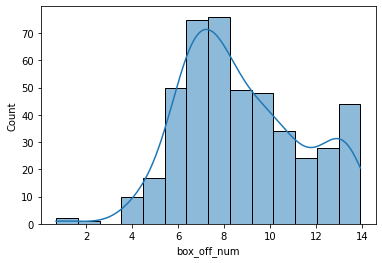

In [ ]:
sns.histplot(np.log1p(train_before_clean["box_off_num"]), kde=True)
plt.show()

LinearRegression

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

#기울기 및 절편, 정확도 등 확인
print("w = 기울기 : " , linear_model.coef_)
print()
print('b = 절편   : ' , linear_model.intercept_)
print()
print('모델의 신뢰도 - ')
y_squared = linear_model.score(X_test, Y_test)
print(y_squared)

w = 기울기 :  [[-1.43232168e-04 -2.09172907e-03  6.15500772e-02  3.01497600e+00
   8.31523398e-04  7.07598120e-02 -1.16351736e-01  6.37263064e-01
   2.50719410e-02  2.03110659e-01 -9.25018861e-02  8.13853599e-01
  -9.24462372e-01]]

b = 절편   :  [-7.517283]

모델의 신뢰도 - 
0.3067287081898311


In [ ]:
Y_prediction = linear_model.predict(X_test).flatten()
# print(Y_prediction[0])
# print(Y_test.values[0][0])
for i in range(20):
    label = Y_test1.values[i][0]
    # label = np.exp(label)
    prediction = Y_prediction[i]
    prediction = np.expm1(prediction)
    print("실제 값: {:.3f}, \t 예측 값: {:.3f}".format(label, prediction))

실제 값: 1351.000, 	 예측 값: 2127.346
실제 값: 162.000, 	 예측 값: 3978.556
실제 값: 3177.000, 	 예측 값: 4584.257
실제 값: 3333.000, 	 예측 값: 4106.077
실제 값: 1176.000, 	 예측 값: 39146.214
실제 값: 862.000, 	 예측 값: 532.231
실제 값: 7453715.000, 	 예측 값: 5304.261
실제 값: 2595.000, 	 예측 값: 9553.344
실제 값: 813.000, 	 예측 값: 3618.642
실제 값: 1561.000, 	 예측 값: 167533.572
실제 값: 1079.000, 	 예측 값: 23248.270
실제 값: 1045.000, 	 예측 값: 11365.403
실제 값: 383582.000, 	 예측 값: 9908.280
실제 값: 3089.000, 	 예측 값: 3956.608
실제 값: 1676040.000, 	 예측 값: 743.721
실제 값: 5105.000, 	 예측 값: 7990.111
실제 값: 1649407.000, 	 예측 값: 6481.850
실제 값: 240.000, 	 예측 값: 10807.391
실제 값: 790370.000, 	 예측 값: 38178.243
실제 값: 1873.000, 	 예측 값: 576.473


In [ ]:
print('예측 - ')
y_pred = linear_model.predict(Z)
y_pred_ar = np.exp(y_pred)
print(y_pred_ar)

예측 - 
[[3.75631754e+04]
 [9.10028732e+04]
 [1.51278903e+05]
 [1.71499444e+05]
 [6.00129115e+04]
 [1.57650629e+04]
 [3.97775749e+03]
 [7.92824792e+03]
 [6.76641513e+03]
 [4.45645467e+04]
 [9.60705005e+04]
 [1.21781992e+05]
 [3.61994330e+04]
 [8.47558599e+03]
 [1.15756906e+05]
 [2.91987676e+05]
 [3.51162748e+03]
 [1.18449566e+05]
 [1.96954076e+04]
 [1.92320884e+03]
 [1.83310132e+03]
 [8.82940196e+03]
 [2.27350334e+04]
 [2.19377968e+03]
 [1.94979828e+03]
 [1.17147380e+05]
 [1.46938034e+03]
 [6.43134791e+04]
 [9.86663635e+03]
 [3.65685578e+04]
 [2.06526250e+04]
 [9.95441615e+02]
 [5.84043898e+03]
 [2.13842977e+05]
 [1.24761223e+04]
 [4.90018939e+03]
 [1.03492677e+04]
 [3.47947060e+03]
 [1.62155612e+04]
 [8.85391711e+02]
 [8.31623519e+04]
 [8.79610420e+03]
 [1.28101020e+04]
 [3.67824354e+04]
 [3.02865519e+04]
 [1.43543658e+05]
 [6.29355209e+03]
 [4.02748183e+04]
 [2.78074220e+04]
 [6.65864008e+03]
 [7.62911888e+03]
 [1.20284286e+04]
 [9.77889376e+03]
 [1.36037399e+05]
 [3.98408095e+04]
 [1.

In [ ]:
deep_4 = submission.copy()
deep_4['box_off_num'] =  y_pred_ar
deep_4.to_csv('deep_4.csv', index = False)
deep_4

,title,box_off_num
0,용서는 없다,37563.175443
1,아빠가 여자를 좋아해,91002.873206
2,하모니,151278.902925
3,의형제,171499.443520
4,평행 이론,60012.911539
...,...,...
238,해에게서 소년에게,1547.710117
239,울보 권투부,3617.161905
240,어떤살인,11749.491764
241,말하지 못한 비밀,11316.421010


In [ ]:
gscv_dtc_model = DecisionTreeClassifier()
param = {
        'criterion':['gini', 'entropy'],
        'max_depth': [1,2,3],  #깊이 - 트리의 노드 갯수
        'min_samples_split': [2, 3], #스플릿 갯수
        'splitter':['random', 'best']
}

grid_tree = GridSearchCV(gscv_dtc_model,
                        param_grid = param,
                        cv = 2,
                        refit = True)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
#                                                    test_size=0.2,
#                                                    random_state=10)
grid_tree.fit(X, Y) #학습
print(type(grid_tree.cv_results_))
grid_tree.cv_results_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 203, in fit
    check_classification_targets(y)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/utils/multicla

ValueError: ignored

In [ ]:
print("최적의 파라미터 확인")
print(grid_tree.best_params_)
print()
print("최적의 파라미터의 정확도")
print(grid_tree.best_score_)
print()
print()
print(grid_tree.best_estimator_)
print(grid_tree.best_index_)

In [ ]:
gscv_dtc_best_model = DecisionTreeClassifier(criterion = 'entropy',
                                            max_depth = 3,
                                            min_samples_split=3,
                                            splitter='random')
gscv_dtc_best_model.fit(X_train, Y_train)
y_pred = gscv_dtc_best_model.predict(X_test)
print("정답 - \n", Y_test)
print()
print("예상 정답 - \n", y_pred)
print()
print("정확도 - \n", accuracy_score(Y_test, y_pred))

- 참고 사이트 https://dacon.io/competitions/open/235536/codeshare/1536?page=1&dtype=vote

https://tensorflow.blog/%EC%BC%80%EB%9D%BC%EC%8A%A4-%EB%94%A5%EB%9F%AC%EB%8B%9D/3-6-%EC%A3%BC%ED%83%9D-%EA%B0%80%EA%B2%A9-%EC%98%88%EC%B8%A1-%ED%9A%8C%EA%B7%80-%EB%AC%B8%EC%A0%9C/
